# Machine Learning Basics for Chemical Engineering Research

## Problem statement
Fraud is a problem for any bank. Fraud can take many forms, whether it is someone stealing a single credit card, to large batches of stolen credit card numbers being used on the web, or even a mass compromise of credit card numbers stolen from a merchant via tools like credit card skimming devices. In this notebook, we provide analysis and insights for Fraud action in credit card transactions. For the challenge, we will use credit card transaction data.
<br>

By following the table of contents, we will find a general description of collected data, detailed illustration and analysis of the dataset, and a predictive model to determine whether a given transaction will be fraudulent or not.

### Table of Contents

I.    [Programmatically load dataset](#Load)<br>
II.   [Plot and general analysis of dataset](#Plot)<br>
III.  [Data Wrangling - Duplicate Transactions](#Clean)<br>
IV.   [Fraud detection model](#Model)<br>
V.   [Future Prospective](#Future)<br>
VI.   [Reference](#Ref)

### Bullet points and logic path
**Question 1: Load</font>**
<br>`a.` Dataset is downloaded and parsed into **pandas DataFrame** through git
<br>`b.` **Shape** of the dataset and **Type**, **Count** of individual features is provided, Features are categories into four groups according to data type 
<br>`c.` **Num of Null**, **Min**, **Max**, **UniqueValue** and **numerical statistics** of individual features is sumerized
<br>`d.` Empty columns **echoBuffer**, **merchantCity**, **merchantState**, **merchantZip**, **posOnPremises**, **recurringAuthInd** are removed

**Question 2: Plot</font>**
<br>`a.` **Histogram plot** and **box chart** of the processed amounts is provided
<br>`b.` **Histogram** of Fraud vs normal transactions are compared
<br>`c.` Majority numeric features follows a **asymmetric distribution patterns**, usually **right skew**
<br>`d.` **Correlation heat map** of features is provided
<br>`e.` **Hypothesis 1:** Fraud transaction are more likely to appear on bigger amount.
<br>`f.` **Hypothesis 2:** If cardCVV is not equal to entered CVV, the corresponding transaction is highly possible to be a Fraud.
<br>`g.` **Hypothesis 3:** Features are not independent between each other (currentbalance, creditlimit, avaiablemoney)

**Question 3: Data Wrangling</font>**
<br>`a.`The dataset contains duplicate items other than Reverse transactions and multi-swipe transactions
<br>`b.`There are **20303** record of reversal transactions, with total amount of **2821792** dollars
<br>`c.`There are **2477** record of multi-swipe transactions, with total amount of **389751** dollars (**repeat transaction with time sequence less then 2mins is treated as multi-swipe**)
<br>`d.`Fraud transactions are more common on **REVERSE** transactions 
<br>`e.`**Time**, **merchantName** features are reshaped before modeling

**Question 4: Model</font>**
<br>`a.` Models are designed to emphasize more on **Sensitivity**
<br>`b.` **Clustering** was tried, but **failed** due to **curse of dimensions**
<br>`c.` **Positively skewed distribution** pattern of specific features are emphasized
<br>`d.` Simple Logistic Regression Model is built with AUC 0.510732
<br>`e.` **Logistic Regression Model** is optimized with **SMOT** technique to deal with **imbalance distribution**
<br>
<br> **Performance of optimized model:**
- Accuracy: 0.98
- Precision: 0.13
- Recall: 0.071
- Average precision-recall score: 0.06
- **AUC** : 0.75

**Future Prospective**
<br>`a.` Multi-normal distribution pattern of **creditLimit** feature should be reshaped, and modified for further improvement 
<br>`b.` Explore other technique to deal with **asymmetric distribution features**, such as **square root** transformation
<br>`c.` Reshape the dataset and use **MySQL** to check for multi-swipe with higher efficiency

In [1]:
import pandas as pd
import os  
import numpy as np
from zipfile import ZipFile
import matplotlib.pyplot as plt
import matplotlib.style as style
import math
import seaborn as sns

### <a class="anchor" id="Load">Part I : Programmatically load dataset</a>

### <font size="+1">Question 1: Load</font>
`1.` Programmatically download and load into your favorite analytical tool the transactions data. This data, which is in line-delimited JSON format, can be found here
<br>
`2.` Please describe the structure of the data. Number of records and fields in each record?
<br>
`3.` Please provide some additional basic summary statistics for each field. Be sure to include a count of null, minimum, maximum, and unique values where appropriate.

**1.** **Extract transform and load data**

In [2]:
# clone Capital One Challenge repository 
!git clone https://github.com/CapitalOneRecruiting/DS.git

fatal: destination path 'DS' already exists and is not an empty directory.


In [3]:
f_name = "DS/transactions.zip"
# read .zip file and extract all files
with ZipFile(f_name, 'r') as zip: 
    # print contents of the corresponding directory
    zip.printdir() 
    # extract all files in transactions.zip
    zip.extractall() 
# since the dataset provided is in json format, we can change the filename and parse to pandas dataFrame
os.rename('transactions.txt','transactions.json')
# convert json strings to pandas dataFrame 
df = pd.read_json ('transactions.json',lines=True)

File Name                                             Modified             Size
transactions.txt                               2020-01-07 21:32:42    609937737


In [4]:
df.to_csv('transaction.csv')

In [5]:
# show example of the dataset
df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,...,,0.0,,,,False,,,False,False
1,737265056,737265056,5000,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,...,,0.0,,,,True,,,False,False
2,737265056,737265056,5000,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
3,737265056,737265056,5000,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
4,830329091,830329091,5000,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,...,,0.0,,,,True,,,False,False


**2.** **Describe the structure of the data**
* The shape of the data set is 786363 (row) * 29 (column)
* There are 3 boolean variables, 4 numerical features, and 22 object features in the dataset, column **isFraud** works are **label data** in model building
* Features could also be categorized into the following 4 class based on datatype and meaning:
    - Customer: customerId, accountNumber
    - Credit: creditLimit, availableMoney, currentExpDate, accountOpenDate, dateOfLastAddressChange, cardCVV, enteredCVV, cardLast4Digits, currentBalance, cardPresent, expirationDateKeyInMatch
    - Mechant: merchantCity, merchantState, merchantZip, merchantName, merchantCountryCode, merchantCategoryCode
    - Transaction: transactionDateTime, transactionAmount, transactionType
    - Pos: posEntryMode, posConditionCode, posOnPremises
* Column echoBuffer, merchantCity, merchantState, merchantZip, posOnPremises, recurringAuthInd are empty columns, thus they **should be removed** for efficiency enhancement while conduct data cleaning

In [6]:
shape = df.shape
print("Dataset Dimensions: {%d} x {%d}" %(shape[0],shape[1]))

Dataset Dimensions: {786363} x {29}


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   accountNumber             786363 non-null  int64  
 1   customerId                786363 non-null  int64  
 2   creditLimit               786363 non-null  int64  
 3   availableMoney            786363 non-null  float64
 4   transactionDateTime       786363 non-null  object 
 5   transactionAmount         786363 non-null  float64
 6   merchantName              786363 non-null  object 
 7   acqCountry                786363 non-null  object 
 8   merchantCountryCode       786363 non-null  object 
 9   posEntryMode              786363 non-null  object 
 10  posConditionCode          786363 non-null  object 
 11  merchantCategoryCode      786363 non-null  object 
 12  currentExpDate            786363 non-null  object 
 13  accountOpenDate           786363 non-null  o

In [8]:
# categorize features according to datatype
time_col = ['dateOfLastAddressChange', 'currentExpDate', 'accountOpenDate', 'transactionDateTime']
int_col = ['cardCVV',  'cardLast4Digits', 'enteredCVV']
cat_col = ['customerId', 'accountNumber','merchantCategoryCode', 'posConditionCode', 'posEntryMode', 'transactionType', 'acqCountry', 'merchantCountryCode']
str_col = ['merchantName']

In [9]:
# fill in empty cells with np.nan 
for col in df.columns:
    df[col] = df[col].map(lambda x: np.nan if x == "" else x)
# check for the number of nan in each column
df_null_count = df.isnull().sum()
empty_col = []
partmiss_col = []
for col in df_null_count.index:
    if df_null_count[col] == shape[0]:
        empty_col.append(col)
    elif df_null_count[col] != 0:
        partmiss_col.append(col)
print("Empty columns:",empty_col)
print("Partial Missing columns",partmiss_col)

Empty columns: ['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd']
Partial Missing columns ['acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode', 'transactionType']


**Empty columns** are droped, while **Partial Missing columns** need to be filled

**<font size="+1">Handle missing Data**
<br>Features with partial missing are classification type of data, thus missing cells can be replaced with nan(string type). Since we already map the missing cells with np.nan, we will just convert them into string type for easier processing

In [10]:
print(partmiss_col)
for col in partmiss_col:
    df[col] = df[col].astype(str)

['acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode', 'transactionType']


In [11]:
df.transactionType.value_counts()

PURCHASE                745193
REVERSAL                 20303
ADDRESS_VERIFICATION     20169
nan                        698
Name: transactionType, dtype: int64

**3.** **Additional basic summary for each field**

In [12]:
# provide discription of each field, including count of null, minimum, maximum, and unique values
from functools import reduce
df_null = pd.DataFrame(df_null_count)
df_min = pd.DataFrame(df.min())
df_max = pd.DataFrame(df.max())
df_uni = pd.DataFrame(df.nunique())

In [13]:
# merge various table to provide insight of dataset structure
dfs = [df_null,df_min,df_max,df_uni]
df_s = reduce(lambda df_left,df_right: pd.merge(df_left,df_right,left_index=True,right_index=True,how='outer'),dfs)
df_s.columns = ["Count of Nulls","Min_value","Max_value","Unique_value"]
df_s

,Count of Nulls,Min_value,Max_value,Unique_value
accountNumber,0,100088067,999389635,5000
customerId,0,100088067,999389635,5000
creditLimit,0,250,50000,10
availableMoney,0,-1005.63,50000,521915
transactionDateTime,0,2016-01-01T00:01:02,2016-12-30T23:59:45,776637
transactionAmount,0,0,2011.54,66038
merchantName,0,1st BBQ,williamssonoma.com,2490
acqCountry,4562,CAN,nan,5
merchantCountryCode,724,CAN,nan,5
posEntryMode,4054,02,nan,6


#### From the above table we can extract the following key infomation:
- There are 5000 unique users in the dataset
- Features **echoBuffer**, **merchantCity**, **merchantState**, **merchantZip**, **posOnPremises**, **recurringAuthInd** are missing 
- Features **acqCountry**, **merchantCountryCode**, **posEntryMode**, **posConditionCode**, **transactionType** have missing elements

In [14]:
# provide statistic information for numerical features
num_col = ['creditLimit','availableMoney','transactionAmount','currentBalance']
df[num_col].describe()

,creditLimit,availableMoney,transactionAmount,currentBalance
count,786363.000000,786363.000000,786363.000000,786363.000000
mean,10759.464459,6250.725369,136.985791,4508.739089
std,11636.174890,8880.783989,147.725569,6457.442068
min,250.000000,-1005.630000,0.000000,0.000000
25%,5000.000000,1077.420000,33.650000,689.910000
50%,7500.000000,3184.860000,87.900000,2451.760000
75%,15000.000000,7500.000000,191.480000,5291.095000
max,50000.000000,50000.000000,2011.540000,47498.810000


From the statistics of numerical features we observe, most of the numerical features follow **asymmetric distribution**. The majority of numeric features **skew to the right** hand side, which indicates a larger portion of transactions concentrated in the small amount range but with high variation.

In [15]:
# drop redundant columns 
df.drop(empty_col, axis = 1, inplace = True)

### <a class="anchor" id="Plot">Part II : Plot and general analysis of dataset</a>

####  <font size="+1">Question 2: Plot
`1.` Plot a histogram of the processed amounts of each transaction, the transactionAmount column.<br>
`2.` Report any structure you find and any hypotheses you have about that structure.

**1.** **Histogram and box chart of the processed amounts of each transaction**<br>

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

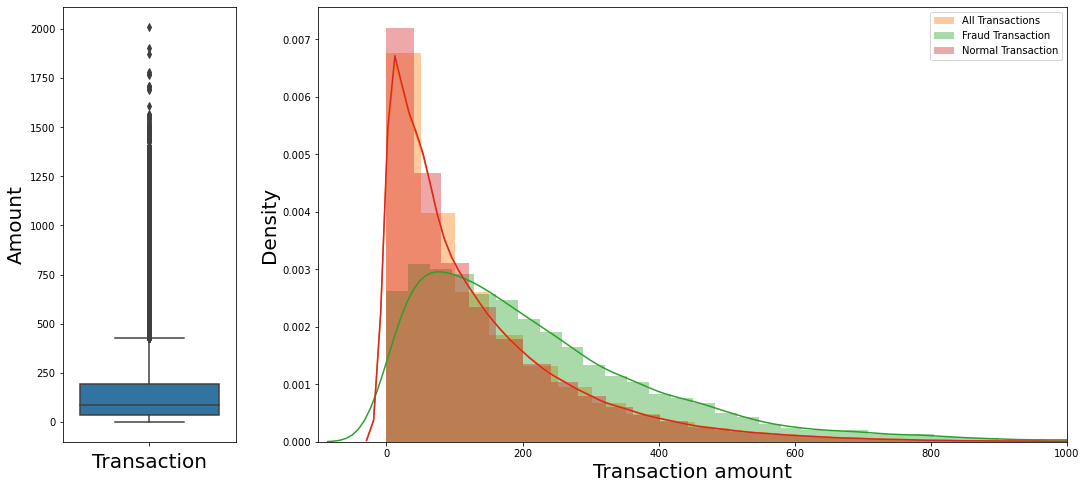

In [16]:
from matplotlib import gridspec
import seaborn as sns
# plot box chart and histogram of each transaction
fig = plt.figure(figsize=(18,8)) 
gs = plt.GridSpec(1, 16, wspace=0.4, hspace=0.6)

# box char
ax0 = plt.subplot(gs[0,0:3])
sns.boxplot(data=df, y ="transactionAmount",color="C0",orient = "Vertical")
ax0.set_ylabel("Amount",fontsize = 20)
ax0.set_xlabel("Transaction",fontsize = 20)

# histogram
ax1 = plt.subplot(gs[0,4:])
Fraud_T = df[df['isFraud'] == True]['transactionAmount']
Fraud_F = df[df['isFraud'] == False]['transactionAmount']
sns.distplot(df['transactionAmount'], hist=True, kde=True, bins=40, color = 'C1',label = "All Transactions")
sns.distplot(Fraud_T , color="C2", label="Fraud Transaction")
sns.distplot(Fraud_F , color="C3", label="Normal Transaction")
ax1.set_ylabel("Density",fontsize = 20)
ax1.set_xlabel("Transaction amount",fontsize = 20)
# Based on average true range, we select range of x-axis as [-100,1000] in the histogram
plt.xlim([-100, 1000])
plt.legend();

**2.** **Report any structure you find and any hypotheses you have about that structure**<br>

In [17]:
# statistic description of numeric features of Fraud transaction
df[df['isFraud']==True][num_col].describe()

,creditLimit,availableMoney,transactionAmount,currentBalance
count,12417.000000,12417.000000,12417.000000,12417.000000
mean,11044.958525,6142.894186,225.215905,4902.064338
std,11943.007883,8703.131117,189.551393,7074.701649
min,250.000000,-614.390000,0.000000,0.000000
25%,5000.000000,1078.020000,86.000000,822.210000
50%,7500.000000,3120.950000,176.980000,2747.390000
75%,15000.000000,7502.820000,311.460000,5644.350000
max,50000.000000,50000.000000,1608.350000,47473.940000


In [18]:
# statistic description of numeric features of Normal transaction
df[df['isFraud'] == False][num_col].describe()

,creditLimit,availableMoney,transactionAmount,currentBalance
count,773946.000000,773946.000000,773946.000000,773946.000000
mean,10754.884062,6252.455386,135.570249,4502.428675
std,11631.136963,8883.600096,146.525305,6446.866656
min,250.000000,-1005.630000,0.000000,0.000000
25%,5000.000000,1077.420000,33.190000,688.032500
50%,7500.000000,3186.145000,86.760000,2446.940000
75%,15000.000000,7500.000000,189.390000,5286.100000
max,50000.000000,50000.000000,2011.540000,47498.810000


Base on the histogram of the processed amount of each transaction, we justify our hypothesis that the distribution **skew to the right**. And the majority of the process concentrated on the 0 to 500 dollar range. If we compare the distribution of Fraud transactions and normal transactions, we believe there is an observable difference between them based on the transaction amounts.

- The distribution of real transaction amounts is more skewed to the right comparing with that of fraud transactions. Based on this observation we proposed **hypothesis 1: Fraud transactions are more likely to appear on the bigger amount.** which makes sense in the realistic condition. 

- Average of real transaction amounts is 136 dollars, much less than the average of fraud transaction amounts, 225 dollars. 50% of real transaction amounts are under 87 dollars also less than that of fraud transaction amounts, under 177 dollars. Meanwhile, 25% of fraud transaction amounts are under 87 dollars, and 50% of normal transaction amounts are under 87 dollars. 

- The maximum transaction amounts of the normal transaction is 2011.54 dollars, 400 dollars larger than the maximum transaction amounts of fraud transaction.

Explanation of **hypothesis 1**: Frauds are less likely to happen among small transactions since the risk of getting caught weighs heavier than the potential gain. Medium to large transactions (50 to 120 dollars) might be the target range for internet fraud.  

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

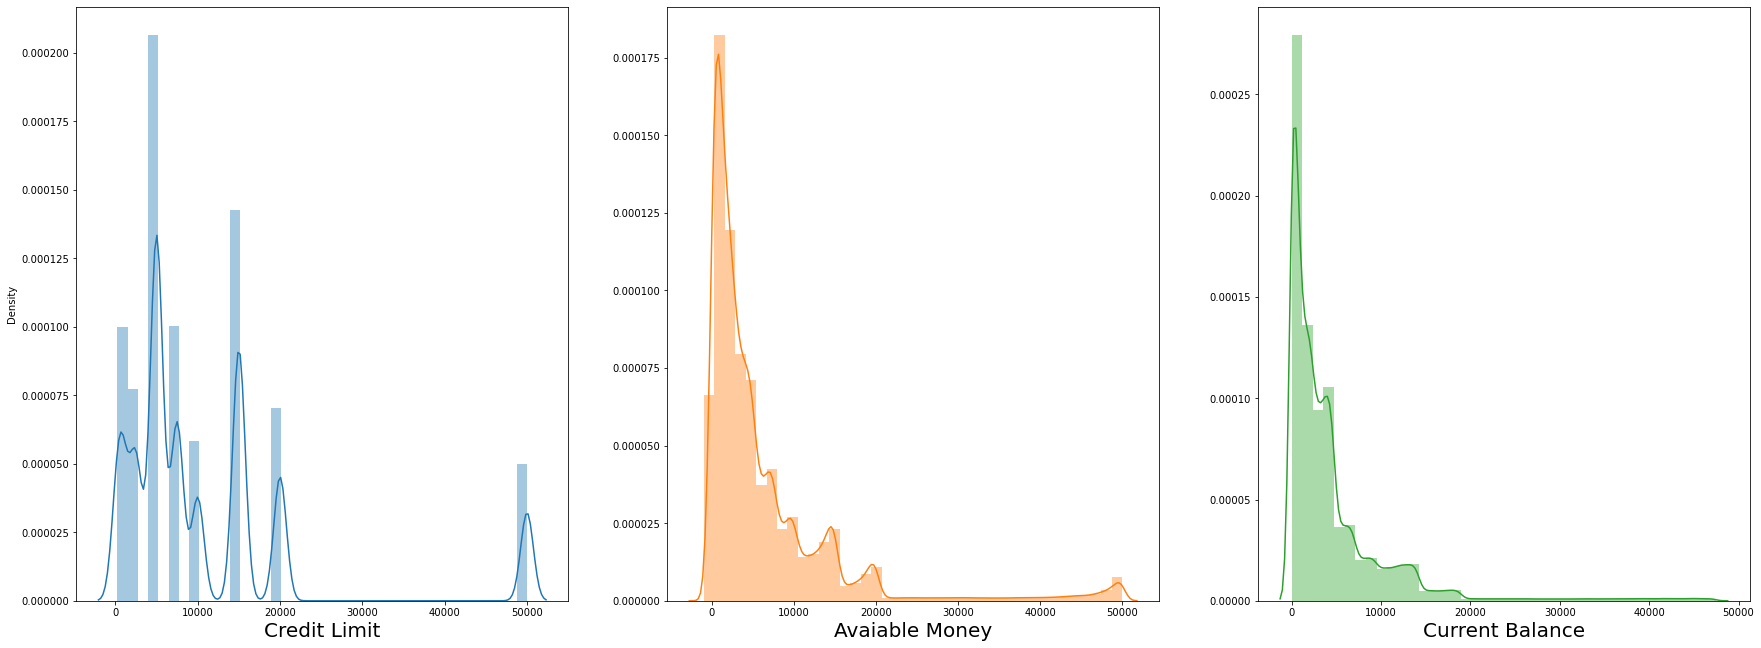

In [19]:
# plot histogram of other numerical features
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30,10))
plt.subplots_adjust(wspace=0.2)
num_col = ['creditLimit', 'availableMoney', 'currentBalance']
col_name = ['Credit Limit', 'Avaiable Money', 'Current Balance']
for i in range(3):
    sns.distplot(df[num_col[i]], ax = ax[i], hist=True, kde=True, bins=40, color = 'C%d' %i)
    ax[i].set_xlabel(col_name[i], fontsize = 20)
    ax[i].set_ylabel('')
ax[0].set_ylabel('Density')
fig.subplots_adjust(top=0.95)

Feature **avaiableMoney** and **currentBalance** follows **positively skewed** distribution pattern. And **creditLimit** follows **multi-Gaussian** distribution. These asymmetric numerical features should be emphasized, and adjusted in model construction.

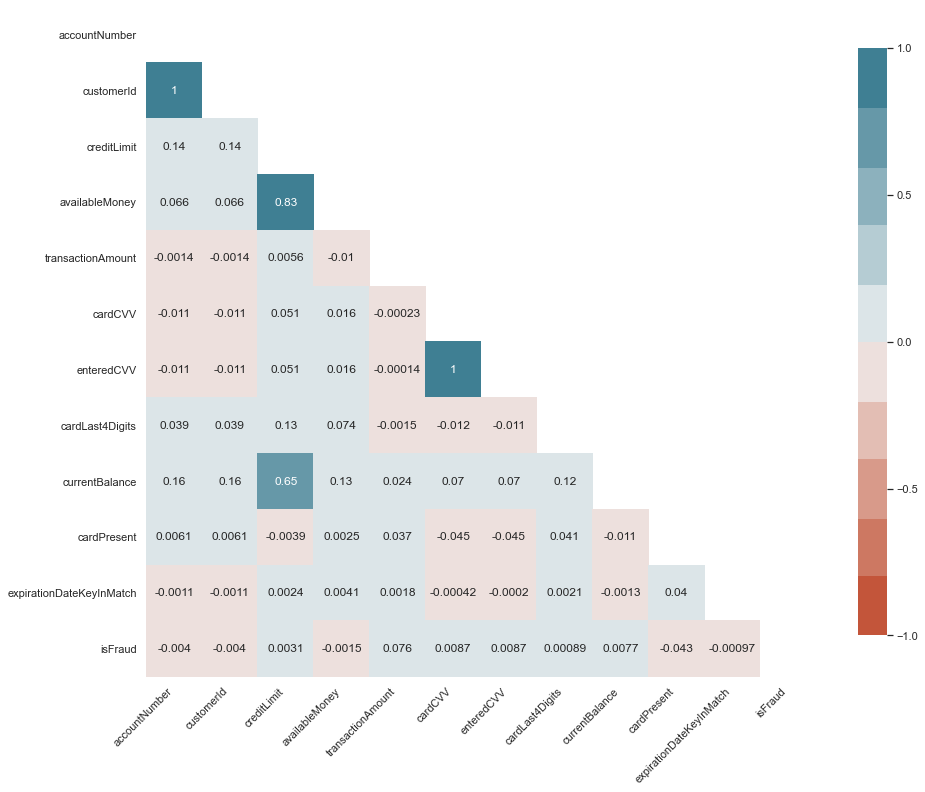

In [20]:
# plot heat map of correlation between variables
corr = df.corr()
# sns heat map https://seaborn.pydata.org/generated/seaborn.heatmap.html
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True
# remove the top right triangle of the heat map
sns.set(font_scale= 1)
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(15, 18))
    sns.heatmap(corr, vmin = -1, vmax = 1,
                center = 0,cmap=sns.diverging_palette(20, 220, n=10),
                annot = True, mask = mask,square = True,
                cbar_kws = {'shrink': .6, 'ticks' : [-1, -.5, 0, 0.5, 1]},
               annot_kws={"size": 12})
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45,horizontalalignment='right')

**Based on the correalation heat map, we observe:**
- feature cardCVV is almost identical to enteredCVV. They are not exactly the same. **Hypothesis 2**: If cardCVV is not equal to entered CVV, the corresponding transaction is highly possible to be a Fraud.    
- current balance can be calculated with available money and credit limit. **Hypothesis 3**: features are not independent of each other
- customerID is the same with accountNumber, in this way one of them should be removed

In [21]:
# Justification of hypothesis 2
df[df['enteredCVV'] != df['cardCVV']].isFraud.value_counts()

False    6812
True      203
Name: isFraud, dtype: int64

In [22]:
# Justification of hypothesis 3
df[df['availableMoney'] == df['creditLimit'] - df['currentBalance']].shape

(534652, 23)

### <a class="anchor" id="Clean">Part III : Data Wrangling - Duplicate Transactions</a>

####  <font size="+1">Question 3: Data Wrangling - Duplicate Transactions
You will notice a number of what look like duplicated transactions in the data set. One type of duplicated transaction is a reversed transaction, where a purchase is followed by a reversal. Another example is a multi-swipe, where a vendor accidentally charges a customer's card multiple times within a short time span.

`1.` Can you programmatically identify reversed and multi-swipe transactions?<br>
`2.` What total number of transactions and total dollar amount do you estimate for the reversed transactions? For the multi-swipe transactions? (please consider the first transaction to be "normal" and exclude it from the number of transaction and dollar amount counts)<br>
`3.` Did you find anything interesting about either kind of transaction?

In [23]:
# check for duplicates before further processing
df.duplicated().value_counts()

False    786363
dtype: int64

There are no complete duplicate record in transaction dataset

**1.** **Identification of reversed and multi-swipe transactions**
<br>**a.** **reversal transactions** 
- Reversal transactions are labeled as **REVERSAL** in the transactionType field
- There are **20303** record of reversal transactions, with total amount of **2821792** dollars

In [24]:
# count number of reversal transations
num_rev = df.transactionType.value_counts()['REVERSAL']
# calculate total dollar amount do of reversal transactions
dollar_rev = df.groupby('transactionType').sum()['transactionAmount']['REVERSAL']
print("There are %s record of reversal transactions, with total amount of %s dollars" %(num_rev,dollar_rev))

There are 20303 record of reversal transactions, with total amount of 2821792.4999999753 dollars


In [25]:
# give an example for purchase and reversal 
df[(df['customerId'] == 574788567)&(df['transactionAmount'] == 215.13)]

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
38,574788567,574788567,2500,2416.11,2016-05-24T01:35:33,215.13,Convenient Tire,US,US,09,...,2015-10-13,2015-10-13,206,206,8522,PURCHASE,83.89,True,False,False
39,574788567,574788567,2500,2200.98,2016-05-24T01:38:03,215.13,Convenient Tire,US,US,09,...,2015-10-13,2015-10-13,206,206,8522,REVERSAL,299.02,True,False,False


**b.** **multi-swipe transactions:**
<br> multi-swipe transactions are transaction processed repreatedly. In this way, muti-swipe transactions should follows 
<br>`1.`have the same **merchantName**, **accountNumber**, **transactionAmount**, **cardLast4Digits**
<br>`2.`difference of **transactionDateTime** between transactions is in short time period (**threshold 2mins**)

In [26]:
# check values in transactionType
df.transactionType.value_counts()

PURCHASE                745193
REVERSAL                 20303
ADDRESS_VERIFICATION     20169
nan                        698
Name: transactionType, dtype: int64

In [27]:
# check if "ADDRESS_VERiFICATION" is real transaction with money processed
df[df['transactionType']=="ADDRESS_VERIFICATION"]['transactionAmount'].sum()

0.0

No money transfered in **ADDRESS_VERIFICATION** type of transactions

**Format unification**

In [28]:
# modify time features
import datetime
df['transactionDateTime'] = df['transactionDateTime'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%dT%H:%M:%S'))
df['accountOpenDate'] = df['accountOpenDate'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
df['currentExpDate'] = df['currentExpDate'].apply(lambda x: datetime.datetime.strptime(x, '%m/%Y'))
df['dateOfLastAddressChange'] = df['dateOfLastAddressChange'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
# unify feature type
for col in int_col:
    df[col] = df[col].astype(int)

In [29]:
# subset out transactionns with money transfer other than "Reverse"
df_t = df[(df['transactionType'] == 'nan')|(df['transactionType'] == "PURCHASE")]
# select record with the same 'customerId','merchantName','transactionAmount', 'cardLast4Digits'
same_col = ['transactionAmount','customerId','merchantName','cardLast4Digits']
df_mul = df_t.groupby(same_col).size().reset_index(name = 'counts')
# select record with repeatition and save a duplicate dataframe
df_dup = df_mul[df_mul['counts'] > 1]

In [30]:
# need to select duplicate record processed in a short period of time
# merger time lable in the df_dup dataset
df_dup_full = pd.merge(df_t,df_dup,on = ['transactionAmount','customerId','merchantName','cardLast4Digits'], how = "inner")[same_col+['transactionDateTime','isFraud']]

In [31]:
from tqdm import tqdm
collection = []
# Building a list of samll dataframes for each multi-transactions with same ['customerId','merchantName','transactionAmount', 'cardLast4Digits']
for i in tqdm(range(len(df_dup))):
    subset = df_dup_full.loc[(df_dup_full.customerId == df_dup_full.iloc[i,1]) 
                       & (df_dup_full.merchantName == df_dup_full.iloc[i,2]) 
                       & (df_dup_full.transactionAmount == df_dup_full.iloc[i,0])
                       & (df_dup_full.cardLast4Digits == df_dup_full.iloc[i,3])]
    subset.sort_values(by='transactionDateTime', ascending=True)
    subset.reset_index(drop=True, inplace = True)
    collection.append(subset)

100%|██████████| 14853/14853 [02:52<00:00, 86.04it/s]


In [32]:
df_mul = pd.DataFrame(columns = collection[0].columns)
# we will get the time interval between transactions, time seq smaller than 2 mins is treated as multi-swap
for row in tqdm(range(len(collection))): 
    for p0 in range(len(collection[row])-1):
        p1 = p0 + 1
        # time label is already sorted
        date0 = collection[row]['transactionDateTime'][p0]
        date1 = collection[row]['transactionDateTime'][p1]
        seq = (date1 - date0).total_seconds()
        if abs(seq) < 120: 
            #Excluding the first 'normal' transaction
            record = collection[row].iloc[p1].to_frame().transpose()
            df_mul = pd.concat([df_mul, record], ignore_index=True)

100%|██████████| 14853/14853 [00:10<00:00, 1430.24it/s]


In [33]:
shape, amount = df_mul.shape, df_mul.transactionAmount.sum()
print("Count of Multi-swipe is %s with total amount of %s" %(shape[0],amount))

Count of Multi-swipe is 2477 with total amount of 389751.1199999983


**2.Total number of transactions and total dollar for the reversed transactions and multi-swipe transactions**

There are **20303** record of reversal transactions, with total amount of **2821792** dollars
<br>There are **2146** record of multi-swipe transactions, with total amount of **450488** dollars 

**3. Interesting patterns**

Text(0.5, 1.0, 'Comparing Transactions between Fraud and Authentic')

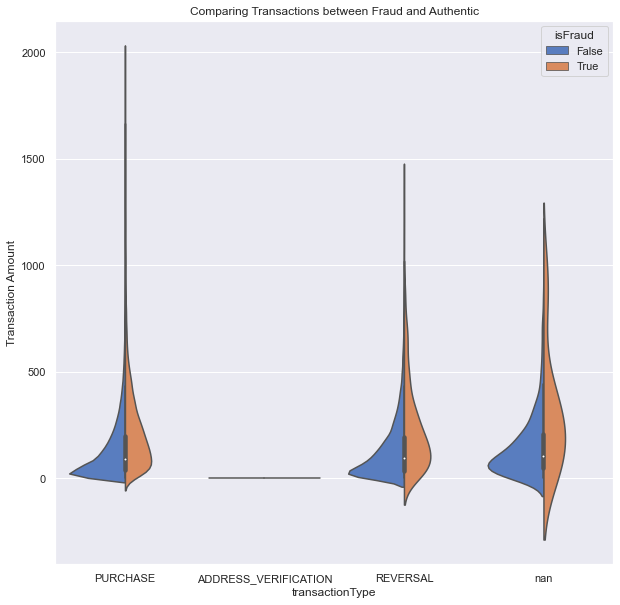

In [34]:
plt.figure(figsize=(10,10))
sns.violinplot(x='transactionType', y='transactionAmount', hue="isFraud", data=df, palette="muted", split=True)
plt.ylabel('Transaction Amount')
plt.title('Comparing Transactions between Fraud and Authentic')

It is interesting to see that fraud transactions are more common in **Reversal** Transactions. People could lose vigilance when conducting a REVERSE Transaction, thus could possibly get caught by the fraud.

**Reshape time features**\
<br> Pure time label might be losely correlated with Fraud action. Reshape time stamp could bring more insight.
<br> We make the hypothesis that Fraud action could relate to the length of time sequece between transaction time and now or account open date. In this way we create two features:
<br>`1.` fromOpenToTransaction = diff (transactionDateTime , accountOpenDate)
<br>`2.` fromTransactionToNow = diff (currentExpDate , transactionDateTime)
<br>`3.` fromTransactionToChange = diff (transactionDateTime,  dateOfLastAddressChange)
<br>`4.` ageOfAccount = diff (currentExpDate , accountOpenDate)

In [35]:
# convert data information to reshaped furtures above
df['fromOpenToTransaction'] = (df['transactionDateTime'] - df['accountOpenDate']).dt.days
df['fromTransactionToNow'] = (df['currentExpDate'] - df['transactionDateTime']).dt.days
df['fromTransactionToChange'] = (df['transactionDateTime'] - df['dateOfLastAddressChange']).dt.days
df['ageOfAccount'] = (df['transactionDateTime'] - df['accountOpenDate']).dt.days

In [36]:
# remove oringinal data from the dataset
df.drop(['accountOpenDate','transactionDateTime','currentExpDate','dateOfLastAddressChange'],axis = 1, inplace = True)

**Reshape merchantName feature**

merchantName is a string object. Simple **one-hot encoding is not a good idea** Since it will lead to the **curse of dimentionality**. In this way, efficiently encoding merchantName feature is required. In this project, we reshape the merchantName feature to **number of times it has received fraud transaction**. And replace the merchantName with Fraud frequency. This procedure may lose some information about the merchant itself, but the idea is worth trying. 

In [37]:
merchant_f = df[df['isFraud']==True]
df_merchant = merchant_f.groupby('merchantName').size()
# encloding merchant name with times of fraud transaction in the dataset, for fast extraction using a hashmap
merchant_dic = df_merchant.to_dict()
df['merchantName'] = df['merchantName'].apply(lambda x: int(merchant_dic[x]) if x in merchant_dic else 0)

### <a class="anchor" id="Model">Part IV : Fraud detection model</a>

####  <font size="+1"> Question 4: Model
Fraud is a problem for any bank. Fraud can take many forms, whether it is someone stealing a single credit card, to large batches of stolen credit card numbers being used on the web, or even a mass compromise of credit card numbers stolen from a merchant via tools like credit card skimming devices.

`1.` Each of the transactions in the dataset has a field called isFraud. Please build a predictive model to determine whether a given transaction will be fraudulent or not. Use as much of the data as you like (or all of it).<br>
`2.` Provide an estimate of performance using an appropriate sample, and show your work.<br>
`3.` Please explain your methodology (modeling algorithm/method used and why, what features/data you found useful, what questions you have, and what you would do next with more time)

Our motivation in this project is to build a predictive model for this **classification problem**. Sensitively catch Fraud transactions are the main target. Since **Flase Positive is more acceptable than False Negative**. In this way, we should emphasize more on **Sensitivity** of the model. Ideally a **top left-shifted ROC curve** is our target. In this dataset we have over 40 features, in this way, working with **clustering (k-mean algorithm) may not be a good idea** since it might lead us to **the curse of dimensions**. 

The difficulty of building a sensitive model is to **deal with the skewed features in the dataset.**. As previously discussed, we found numerical features, such as **availableMoney**, **currentBalance** are extremely **right skewed**. Solving the problem of imbalanced features requires some extra thoughts.   

Due to the **time and computational resource limit**, I decided to focus on **Logistic Regression**. Even though It do not work well with imbalanced data, it can still be optimized with **Over sampling** techniques, which leave room for further modification. <br>
<br>`a.` Logistic Regression can quickly classify large volumes of data with relatively low computational cost
<br>`b.` The predictive analytics algorithms can be enhanced using **Oversampling technique**. And improve the model performance on **asymmetric features**.

In [38]:
# prepare the training matrix for modeling
# category features require tokenization
cat_col = ['posConditionCode','merchantCountryCode','acqCountry','merchantCategoryCode','transactionType','posEntryMode']
df_cat = pd.get_dummies(df[cat_col])
# merge the remaining part of the dataset
df_res = df.drop(cat_col,axis = 1)
df_clean = pd.concat([df_cat, df_res], axis=1)

In [39]:
df_clean.isFraud.value_counts()

False    773946
True      12417
Name: isFraud, dtype: int64

In [40]:
# save cleaning dataset as backup
df_clean.to_csv('transaction_clean.csv', index=False)

**Logistic Regression** (without asymmetry adjustment)
<br>
Simpe logistic regression model is built for a start. Without considering **asymmetry distribution** of features. **Theoretically, the result should not look good**

In [41]:
df_clean = pd.read_csv('transaction_clean.csv')

In [42]:
# select X for features set, y for label set
X_features = list(set(df_clean.columns) - set(['isFraud']))
X = df_clean[X_features]
Y = df_clean['isFraud']
print(X.shape,Y.shape)

(786363, 59) (786363,)


In [43]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_curve, auc
from sklearn import metrics

**Evluation of Simple Logistic Regression model** 
<br> Evaluation sheet contains the following features:
<br>`a.` Accuracy, precision, Recall number, Average Precison-recall Score
<br>`b.` Confusion matrix
<br>`c.` ROC Curve

In [44]:
## modified according to the following link: http://localhost:8889/tree/Documents/Github/scikit-learn-videos
from sklearn import linear_model, datasets
import pylab as pl
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score 
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, accuracy_score

# plot roc curve of corresponding model
def draw_ROC(model, xtrain, xvalid, xtest, ytrain, yvalid, ytest):
    probas_0 = model.predict_proba(xtrain)[:,1]
    probas_1 = model.predict_proba(xvalid)[:,1]
    probas_2 = model.predict_proba(xtest)[:,1]
    
    fpr_0, tpr_0, thresholds_0 = roc_curve(ytrain, probas_0)
    fpr_1, tpr_1, thresholds_1 = roc_curve(yvalid, probas_1)
    fpr_2, tpr_2, thresholds_2 = roc_curve(ytest, probas_2)
    
    roc_auc_0 = auc(fpr_0, tpr_0)
    roc_auc_1 = auc(fpr_1, tpr_1)
    roc_auc_2 = auc(fpr_2, tpr_2)
    
    # Plot ROC curve
    plt.figure(figsize=(5,5))
    plt.plot(fpr_0, tpr_0, label='ROC curve - train(AUC = %0.2f)' % roc_auc_0, color='r')
    plt.plot(fpr_1, tpr_1, label='ROC curve - validation (AUC = %0.2f)' % roc_auc_1, color='b')
    plt.plot(fpr_2, tpr_2, label='ROC curve - test (AUC = %0.2f)' % roc_auc_2, color='g')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FP Rate')
    plt.ylabel('TP Rate')
    plt.title('ROC')
    plt.legend()
    plt.show()
    
    print("Area under the ROC curve - train: %f" % roc_auc_0)
    print("Area under the ROC curve - val: %f" % roc_auc_1)
    print("Area under the ROC curve - test: %f" % roc_auc_2)
    
def plot_confusion(y_pred, y_test):
    conf = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    sns.heatmap(conf,
                cmap= sns.diverging_palette(20, 220, n=10),
                cbar=False,
                annot=True,
                fmt='g',
                xticklabels=['False', 'True'],
                yticklabels=['False', 'True'],
                annot_kws={"size": 15}
                )
    plt.show()
    
# define evaluation content
def evaluation(model, xtrain, xvalid, xtest, ytrain, yvalid, ytest, threshold):
    y_prob = model.predict_proba(xtest)[:,1]
    # first column is the probability of the predicted output being False, second column represent True
    y_pred_default = model.predict(xtest)
    y_pred = (y_prob >= threshold).astype(bool)
    average_precision = average_precision_score(ytest, y_prob)  
    # visualize confusion_matrix
    plot_confusion(y_pred,ytest)
    print("Accuracy:", metrics.accuracy_score(ytest, y_pred_default))
    print("Precision:", metrics.precision_score(ytest, y_pred_default))
    print("Recall:", metrics.recall_score(ytest, y_pred_default))
    print('Average precision-recall score: {0:0.2f}'.format(average_precision))
    
    # plot roc_curve
    draw_ROC(model, xtrain, xvalid, xtest, ytrain, yvalid, ytest)

In [45]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
X = scale.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.25)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, stratify=y_train, test_size=0.25)
print(X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape)

(442329, 59) (147443, 59) (196591, 59) (442329,) (147443,) (196591,)


In [46]:
# standardized the dataset and train the model using logistic regression
# use logistic regression model to fit standarized dataset
lg = LogisticRegression(solver='liblinear', penalty = 'l1', random_state = 0, max_iter = 200)
lg.fit(X_train, y_train)

LogisticRegression(max_iter=200, penalty='l1', random_state=0,
                   solver='liblinear')

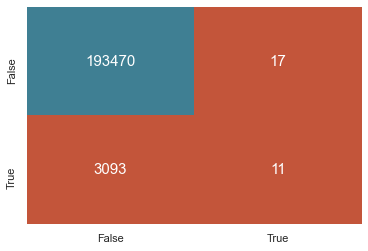

Accuracy: 0.9842057876505028
Precision: 0.0
Recall: 0.0
Average precision-recall score: 0.06


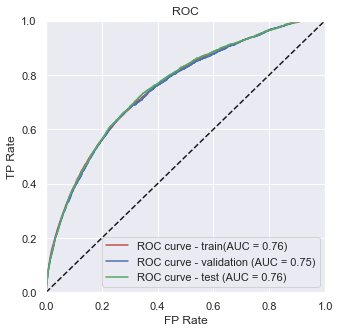

Area under the ROC curve - train: 0.756330
Area under the ROC curve - val: 0.753041
Area under the ROC curve - test: 0.757568


In [47]:
evaluation(lg, X_train, X_valid, X_test, y_train, y_valid, y_test, threshold = 0.35)

**Logistic Regression (with Oversampling technique)**

**Assymetry adjustment**

https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
<br>
Recently showed **Synthetic Minority Oversampling Technique** (SMOTE) performs better when combined with undersampling of the majority class, such as random undersampling. We can update the traning set to first oversample the minority class to have 10 percent the number of examples of the majority class, then use random undersampling to reduce the number of examples in the majority class to have 50 percent more than the minority class.

In [48]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
def upsample_SMOTE(X_train, y_train, over_r, under_r):
    # ratio argument is the percentage of the upsampled minority class in relation to the majority class
    over = SMOTE(sampling_strategy = over_r)
    under = RandomUnderSampler(sampling_strategy = under_r)
    steps = [('over', over), ('under', under)]
    pipeline = Pipeline(steps=steps)
    X_train_sm, y_train_sm = pipeline.fit_resample(X_train, y_train)
    return X_train_sm, y_train_sm

In [54]:
# oversampling on the standardized the training set using SMOTE technique
X_train_sm, y_train_sm = upsample_SMOTE(X_train, y_train, over_r = 0.15, under_r = 0.4)

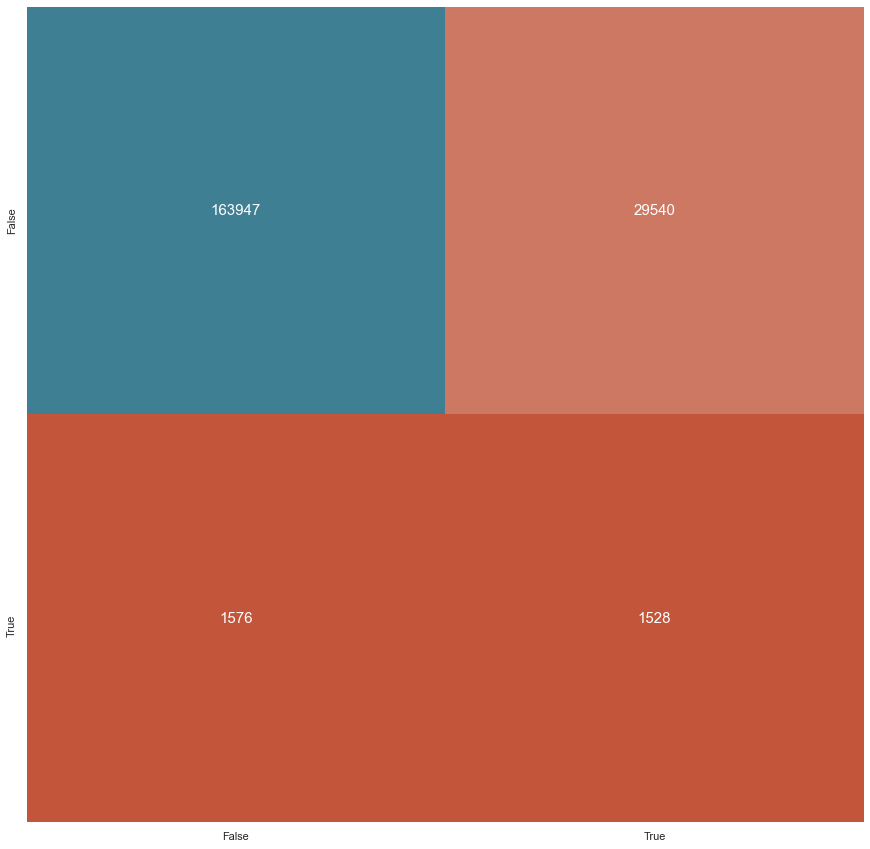

Accuracy: 0.9192435055521362
Precision: 0.06681590014923348
Recall: 0.3173324742268041
Average precision-recall score: 0.06


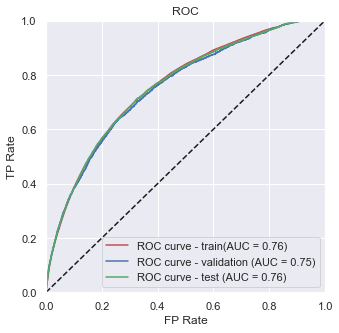

Area under the ROC curve - train: 0.758884
Area under the ROC curve - val: 0.752789
Area under the ROC curve - test: 0.757334


In [55]:
lg_SMOT = LogisticRegression(solver='liblinear', penalty = 'l1',random_state= True, max_iter = 200)
lg_SMOT.fit(X_train_sm, y_train_sm)
evaluation(lg_SMOT, X_train_sm, X_valid, X_test, y_train_sm, y_valid, y_test, threshold = 0.4)

**Comparison of two models**

Logistic regression model (with SMOT oversampling) perform better compared with simple logistic regression model. With detailed comparison showed in the following figure:

![](modelresult.png)

**Optimized model is evaluated as**
- Accuracy: 0.9780407037962063
- Precision: 0.13309134906231096
- Recall: 0.07087628865979381
- Average precision-recall score: 0.06
- Average precision-recall score: 0.06
- Area under the ROC curve : 0.748089

### <a class="anchor" id="Future">Part V : Future Prospective</a>

<br>`a.` Multi-normal distribution pattern of **creditLimit** feature should be reshaped, and modified for further improvement 
<br>`b.` Explore other technique to deal with **asymmetric distribution features**, such as **square root** transformation
<br>`c.` Apply **parallel computation** to enhance training efficiency
<br>`d.` Reshape the dataset and use **MySQL** to check for multi-swipe with higher efficiency 

We observe feature **creditLimit** adopted multi-normal distribution pattern, which could introduce errors in building classification models. Transformation of this feature should be conducted to optimize the model. Meanwhile, other algorithms to deal with asymmetric patterns should be tested, in this situation map, numeric features with their square root can be adopted for trial. Meanwhile, the solution to find **multi-swipe** is too slow in this case, it will be much faster to use a relational database to extract those information. For efficiency enhancment, I proposed to reshape the dataset, and use MySQL as platform to extract multi-swipe information. 

### <a class="anchor" id="ref">Part VI : Reference</a>

https://seaborn.pydata.org/generated/seaborn.heatmap.html
<br> https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
<br> http://localhost:8889/tree/Documents/Github/scikit-learn-videos

array([[<AxesSubplot:title={'center':'creditLimit'}>,
        <AxesSubplot:title={'center':'availableMoney'}>],
       [<AxesSubplot:title={'center':'currentBalance'}>,
        <AxesSubplot:title={'center':'cardCVV'}>],
       [<AxesSubplot:title={'center':'cardLast4Digits'}>,
        <AxesSubplot:title={'center':'enteredCVV'}>]], dtype=object)

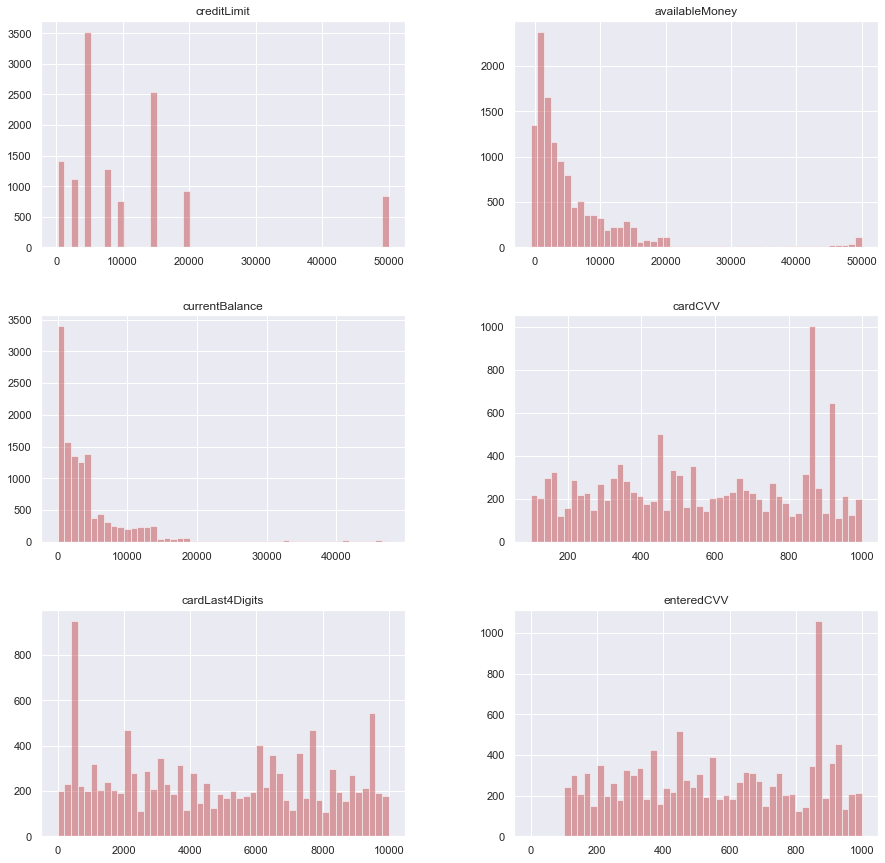

In [51]:
plt.rcParams["figure.figsize"] = (15,15)
df[df['isFraud']==True][num_col+int_col+cat_col].hist(color="r", alpha=0.5, bins=50)

array([[<AxesSubplot:title={'center':'creditLimit'}>,
        <AxesSubplot:title={'center':'availableMoney'}>],
       [<AxesSubplot:title={'center':'currentBalance'}>,
        <AxesSubplot:title={'center':'cardCVV'}>],
       [<AxesSubplot:title={'center':'cardLast4Digits'}>,
        <AxesSubplot:title={'center':'enteredCVV'}>]], dtype=object)

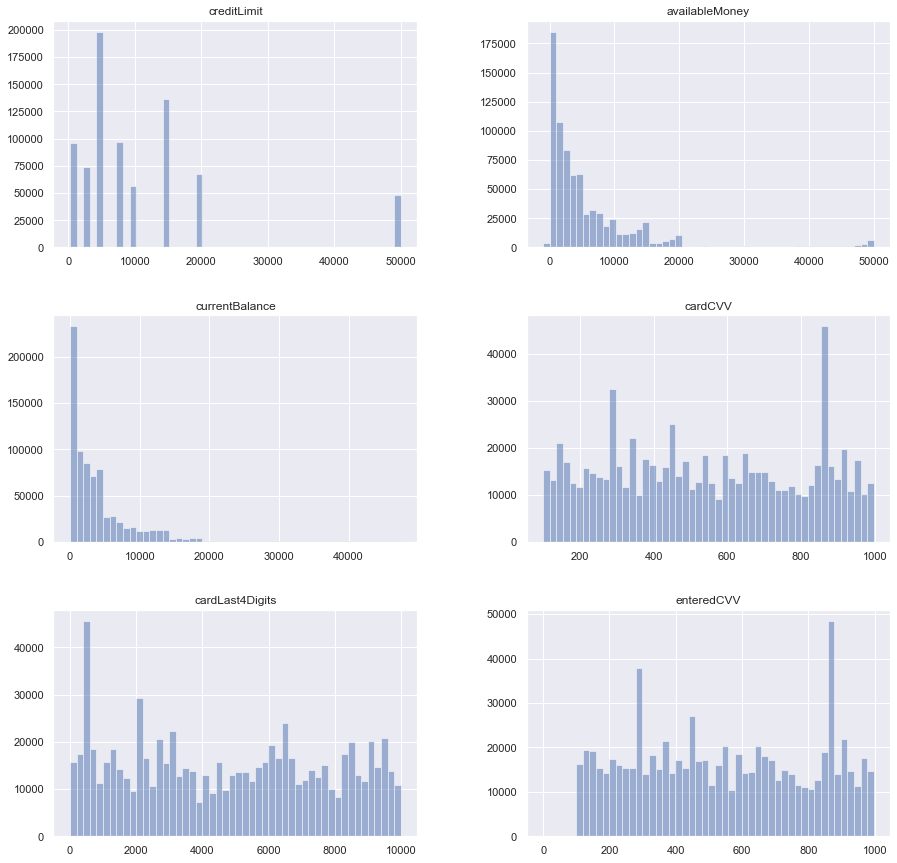

In [52]:
plt.rcParams["figure.figsize"] = (15,15)
df[df['isFraud']==False][num_col+int_col+cat_col].hist(color="b", alpha=0.5, bins=50)